In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2023-11-18 01:42:49.217312: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 01:42:49.462174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 01:42:49.462304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 01:42:49.462816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 01:42:49.564343: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 01:42:49.566909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
#tried loading as .keras and .hf but neither worked

model = tf.keras.models.load_model('models/just_a_dense')

# Show the model architecture
model.summary()

2023-11-18 01:42:52.006766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 01:42:52.007182: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 37)                75        
 on)                                                             
                                                                 
 dense (Dense)               (None, 200)               7600      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                      

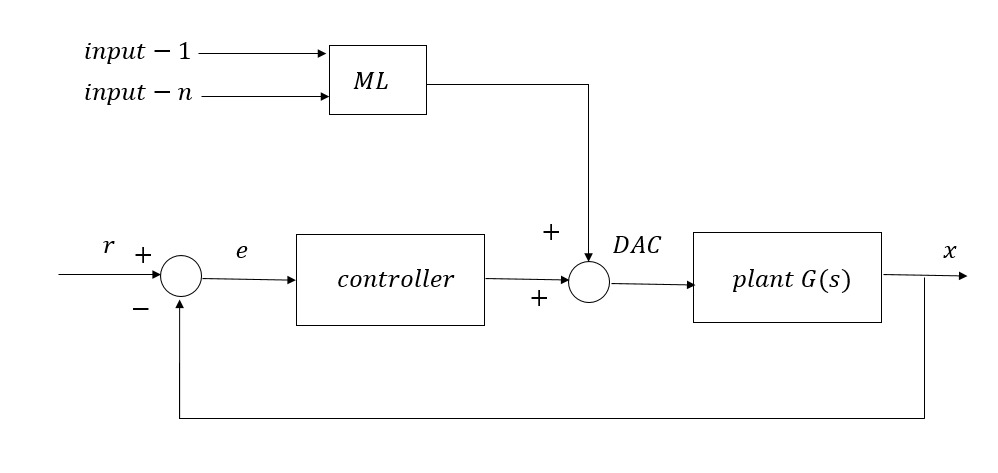

In [1]:
#this is the controll diagram:

from IPython.display import Image

Image("images/controll_diagram.jpg")

In [ ]:
'''
ok so assuming that our machine learning model is good enough to get an accurate prediction of the current position of the endpoint
how do we go from this -> dac input?

we have to assume that the cmd position is the desired endpoint position aswell
#so lets first see the difference between the command position and the endpoint (acceleration / position values)

'''

In [3]:
#so lets first see the difference between the command position and the endpoint (acceleration / position values)

test = pd.read_csv('Data/test_data_new.csv')

In [4]:
data = test[test["file"] == 7]

In [5]:
data = data[:7500] #just segmenting for testing

In [6]:
data.columns

Index(['sample', 'CMD_POS_FLOATMAG_BH', 'ENC_POS_FLOATMAG_BH',
       'POS_ERR_FLOATMAG_BH', 'DAC_FLOATMAG_BH', 'FLOATMAG_ACC_ADC_PORT_0',
       'dENC_X', 'ddENC_X', 'rolling_mean_ENC_POS_10',
       'rolling_var_ENC_POS_10', 'rolling_slope_ENC_POS_10',
       'rolling_mean_ENC_POS_30', 'rolling_var_ENC_POS_30',
       'rolling_slope_ENC_POS_30', 'rolling_mean_ENC_POS_50',
       'rolling_var_ENC_POS_50', 'rolling_slope_ENC_POS_50', 'dDAC', 'ddDAC',
       'rolling_mean_DAC_10', 'rolling_var_DAC_10', 'rolling_slope_DAC_10',
       'rolling_mean_DAC_30', 'rolling_var_DAC_30', 'rolling_slope_DAC_30',
       'rolling_mean_DAC_50', 'rolling_var_DAC_50', 'rolling_slope_DAC_50',
       'dPOS_ERR', 'ddPOS_ERR', 'rolling_mean_POS_ERR_10',
       'rolling_var_POS_ERR_10', 'rolling_slope_POS_ERR_10',
       'rolling_mean_POS_ERR_30', 'rolling_var_POS_ERR_30',
       'rolling_slope_POS_ERR_30', 'rolling_mean_POS_ERR_50',
       'rolling_var_POS_ERR_50', 'rolling_slope_POS_ERR_50', 'file'],
     

In [16]:
prediction_timestep = 1

data["target"] = test["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)

In [17]:
data["target_velocity"] = (-data["target"]).expanding().apply(lambda x: np.trapz(x, dx = 1/8000))
data["target_position"] = data["target_velocity"].expanding().apply(lambda x: np.trapz(x, dx = 1/8000))

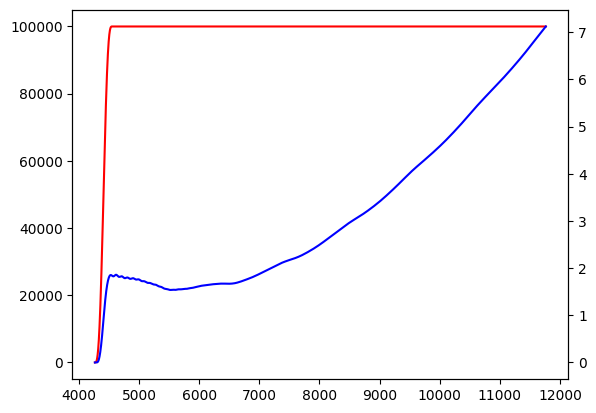

In [18]:
fig, ax1 = plt.subplots()

ax1.plot(data["CMD_POS_FLOATMAG_BH"], "r")

ax2 = ax1.twinx()

ax2.plot(data["target_position"], "b")

In [19]:
#simpsons rule integration
from scipy.integrate import simps
data["target_velocity"] = (-data["target"]).expanding().apply(lambda x: simps(x, dx=1/8000))
data["target_position"] = data["target_velocity"].expanding().apply(lambda x: simps(x, dx=1/8000))

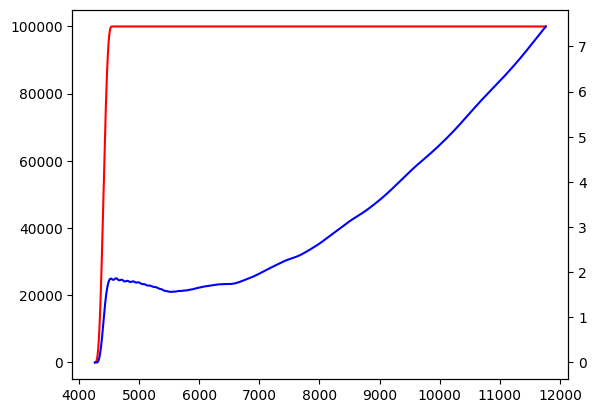

In [20]:
fig, ax1 = plt.subplots()

ax1.plot(data["CMD_POS_FLOATMAG_BH"], "r")

ax2 = ax1.twinx()

ax2.plot(data["target_position"], "b")

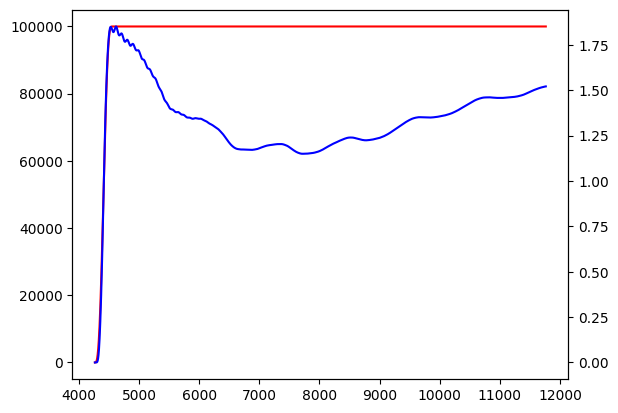

In [21]:
#try to correct for drift by subtracting mean:


data["target_velocity"] = (-data["target"] - (-data["target"]).mean()).expanding().apply(lambda x: simps(x, dx=1/8000))
data["target_position"] = data["target_velocity"].expanding().apply(lambda x: simps(x, dx=1/8000))

fig, ax1 = plt.subplots()

ax1.plot(data["CMD_POS_FLOATMAG_BH"], "r")

ax2 = ax1.twinx()

ax2.plot(data["target_position"], "b")



In [31]:
data["target_position"].max()
#ok so count of 100000 is equivelent to 1.852 of the endpoint position value
#have to multiply endpoint position value by 270.0 to get conversion to um

#500 / 1.852 

269.97840172786175

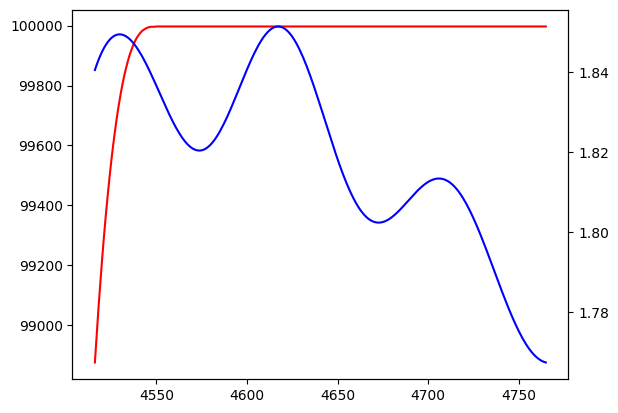

In [22]:
#the actual vibrations that we care about are the small pertubations that we can see right after the big movement, the rest of it may be due to noise / error in measurement
#lets try to get an estimate of the magnitude of maximum magnitude of the vibrations and see if this is alligned with our expectations
#we have to use the known range of reference which is the encoder position (measured in count), where 100000 = 500um
#and we also know that the endpoint position and encoder position are meant to be the same ideally, so we can use encoder scale as reference
#ok so it looks like its in the range of (100000 - 99300) = 700 and the conversion is 100000 = 500um, so 700 = 3.5um


fig, ax1 = plt.subplots()

ax1.plot(data["CMD_POS_FLOATMAG_BH"].iloc[250:500], "r")

ax2 = ax1.twinx()

ax2.plot(data["target_position"].iloc[250:500], "b")

In [26]:
train_columns = ['CMD_POS_FLOATMAG_BH', 'ENC_POS_FLOATMAG_BH', 'POS_ERR_FLOATMAG_BH',
       'DAC_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'rolling_mean_ENC_POS_10',
       'rolling_var_ENC_POS_10', 'rolling_slope_ENC_POS_10',
       'rolling_mean_ENC_POS_30', 'rolling_var_ENC_POS_30',
       'rolling_slope_ENC_POS_30', 'rolling_mean_ENC_POS_50',
       'rolling_var_ENC_POS_50', 'rolling_slope_ENC_POS_50', 'dDAC', 'ddDAC',
       'rolling_mean_DAC_10', 'rolling_var_DAC_10', 'rolling_slope_DAC_10',
       'rolling_mean_DAC_30', 'rolling_var_DAC_30', 'rolling_slope_DAC_30',
       'rolling_mean_DAC_50', 'rolling_var_DAC_50', 'rolling_slope_DAC_50',
       'dPOS_ERR', 'ddPOS_ERR', 'rolling_mean_POS_ERR_10',
       'rolling_var_POS_ERR_10', 'rolling_slope_POS_ERR_10',
       'rolling_mean_POS_ERR_30', 'rolling_var_POS_ERR_30',
       'rolling_slope_POS_ERR_30', 'rolling_mean_POS_ERR_50',
       'rolling_var_POS_ERR_50', 'rolling_slope_POS_ERR_50']

train_data = data[train_columns]

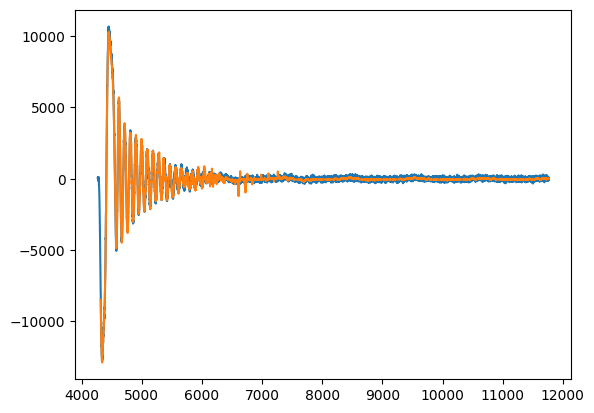

In [33]:
#getting predictions from model:

data["predictions"] = model(train_data) #this is in acceleration (already output scaled)

plt.plot(data["target"])
plt.plot(data["predictions"])


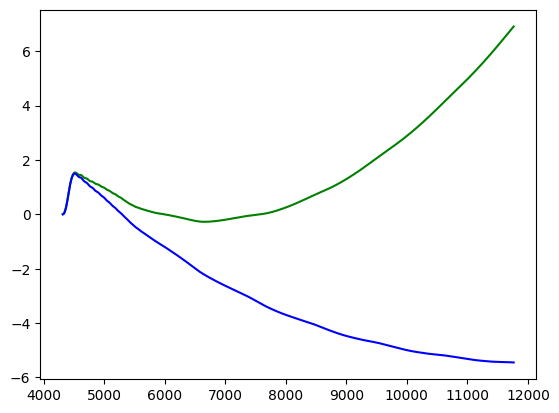

In [71]:
#right so we wanted to see how our acceleration preditions compare when integrated to the actual position
prediction_position = (-data["predictions"].iloc[49:] - (-data["target"].iloc[49:]).mean()).expanding().apply(lambda x: np.trapz(x, dx = 1/8000)).expanding().apply(lambda x: simps(x, dx=1/8000))

target_position = (-data["target"].iloc[49:] - (-data["target"].iloc[49:]).mean()).expanding().apply(lambda x: simps(x, dx=1/8000)).expanding().apply(lambda x: simps(x, dx=1/8000))

plt.plot(prediction_position, "g")

plt.plot(target_position, "b")

# plt.xlim(4200,5200)

# plt.ylim(-2, 2)

In [65]:
def low_pass(array, sampling_rate = 8000, cutoff_frequency = 200):
    from scipy.signal import butter, filtfilt

    # Calculate the Nyquist frequency
    nyquist_frequency = sampling_rate / 2.0

    filter_order = 2  # Second-order filter, can be increased for a steeper roll-off

    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

    filtered_array = (filtfilt(b, a, array))

    return filtered_array



In [68]:
pd.Series((-low_pass(data["predictions"].iloc[49:]))).expanding()

Expanding [min_periods=1,axis=0,method=single]

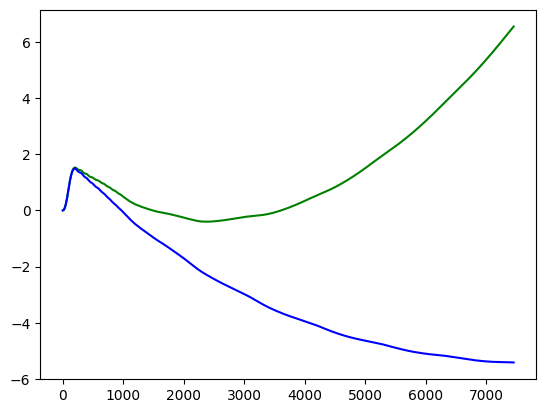

In [70]:
#filtered
prediction_position_filtered = pd.Series(-low_pass(data["predictions"].iloc[49:])).expanding().apply(lambda x: np.trapz(x, dx = 1/8000)).expanding().apply(lambda x: simps(x, dx=1/8000))

target_position_filtered = pd.Series(-low_pass(data["target"].iloc[49:])).expanding().apply(lambda x: simps(x, dx=1/8000)).expanding().apply(lambda x: simps(x, dx=1/8000))

plt.plot(prediction_position_filtered, "g")

plt.plot(target_position_filtered, "b")

# plt.xlim(4200,5200)

# plt.ylim(-2, 2)

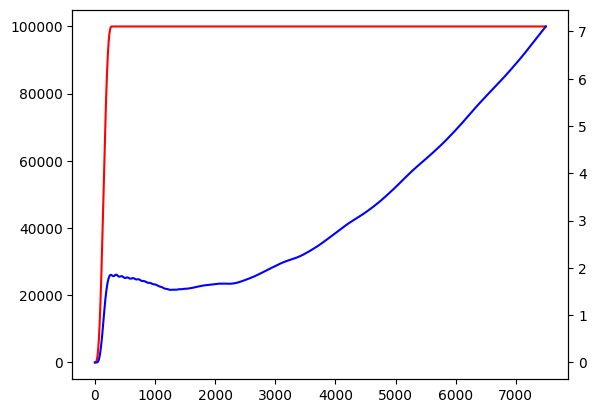

In [85]:


# Apply the filter to the acceleration data
filtered_acc = -low_pass(data["FLOATMAG_ACC_ADC_PORT_0"], cutoff_frequency = 200)

# Apply zero-offset correction if needed
# filtered_acc_corrected = filtered_acc - np.mean(filtered_acc)
filtered_acc_corrected = filtered_acc 

# Integrate velocity to get position
endpoint_position = pd.Series(filtered_acc_corrected).expanding().apply(lambda x: np.trapz(x, dx = 1/8000)).expanding().apply(lambda x: np.trapz(x, dx = 1/8000))

fig, ax1 = plt.subplots()

ax1.plot(data["CMD_POS_FLOATMAG_BH"].values, "r")

ax2 = ax1.twinx()

ax2.plot(endpoint_position.values, "b")


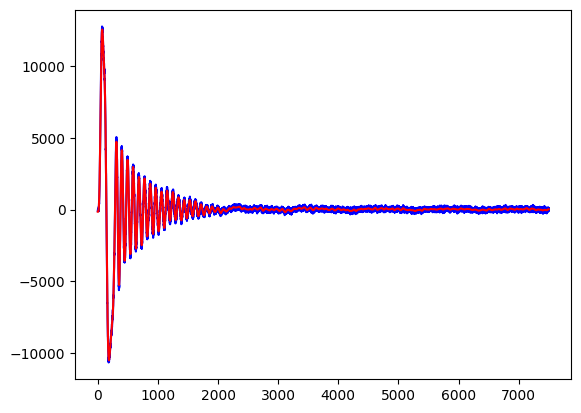

In [86]:
plt.plot(-data["FLOATMAG_ACC_ADC_PORT_0"].values, "b")
plt.plot(filtered_acc_corrected, "r")


In [ ]:
#ok i guess the only thing we can do at this point is try to figure out the correlation between the pos err and the dac input
#because given this we can infer their correction mechanism

#we also need to see how dac affects encoder position

#we then need to determine the dac input required to correct for the endpoint pos err


In [94]:
test["file"].unique()

array([ 3,  7, 13, 16, 20, 23])

In [104]:
test.columns

Index(['sample', 'CMD_POS_FLOATMAG_BH', 'ENC_POS_FLOATMAG_BH',
       'POS_ERR_FLOATMAG_BH', 'DAC_FLOATMAG_BH', 'FLOATMAG_ACC_ADC_PORT_0',
       'dENC_X', 'ddENC_X', 'rolling_mean_ENC_POS_10',
       'rolling_var_ENC_POS_10', 'rolling_slope_ENC_POS_10',
       'rolling_mean_ENC_POS_30', 'rolling_var_ENC_POS_30',
       'rolling_slope_ENC_POS_30', 'rolling_mean_ENC_POS_50',
       'rolling_var_ENC_POS_50', 'rolling_slope_ENC_POS_50', 'dDAC', 'ddDAC',
       'rolling_mean_DAC_10', 'rolling_var_DAC_10', 'rolling_slope_DAC_10',
       'rolling_mean_DAC_30', 'rolling_var_DAC_30', 'rolling_slope_DAC_30',
       'rolling_mean_DAC_50', 'rolling_var_DAC_50', 'rolling_slope_DAC_50',
       'dPOS_ERR', 'ddPOS_ERR', 'rolling_mean_POS_ERR_10',
       'rolling_var_POS_ERR_10', 'rolling_slope_POS_ERR_10',
       'rolling_mean_POS_ERR_30', 'rolling_var_POS_ERR_30',
       'rolling_slope_POS_ERR_30', 'rolling_mean_POS_ERR_50',
       'rolling_var_POS_ERR_50', 'rolling_slope_POS_ERR_50', 'file'],
     

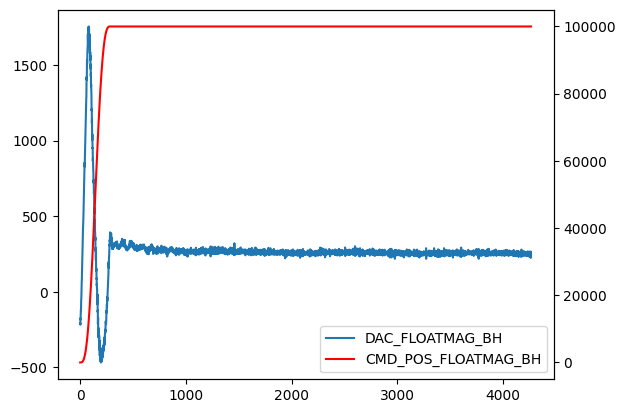

In [116]:
file_num = 3
plt.plot(test[test["file"] ==file_num]["DAC_FLOATMAG_BH"].values, label = "DAC_FLOATMAG_BH")

ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(test[test["file"] ==file_num]["CMD_POS_FLOATMAG_BH"].values, "r", label = "CMD_POS_FLOATMAG_BH")

#display the legend

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine legends and display
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")


In [ ]:
#questions:

#

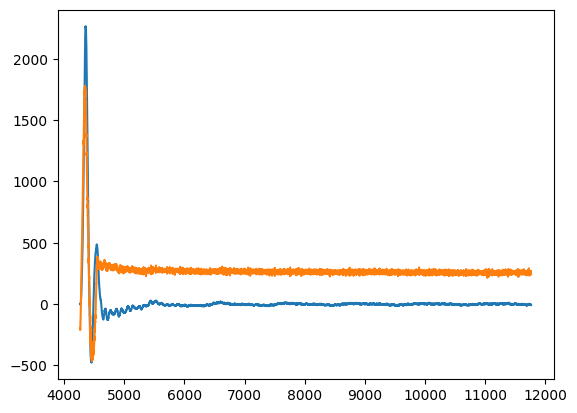

In [91]:
plt.plot(data["POS_ERR_FLOATMAG_BH"])
plt.plot(data["DAC_FLOATMAG_BH"])